In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd

from IPython.display import display, Image
from sklearn.metrics import roc_auc_score, roc_curve

from utils import get_class, load_data_sources, reset_seeds, get_positive_samples
from constants import protein_list, protein_names, experiment_set

style.use('seaborn-poster')

#Set random seeds for reproducibility.
reset_seeds()

Using TensorFlow backend.
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alovse/minicon

In [2]:
receptive_field = 0
receptive_field_previous = 1
filters = [6,20,4,40,4,30,3]
layers = ['conv1','pool1','conv2','pool2','conv3','pool3','conv4']

for i, filter_size in enumerate(filters):
    receptive_field = receptive_field_previous + filter_size - 1
    print('ERF of layer {} is {}'.format(layers[i], receptive_field))
    receptive_field_previous = receptive_field

ERF of layer conv1 is 6
ERF of layer pool1 is 25
ERF of layer conv2 is 28
ERF of layer pool2 is 67
ERF of layer conv3 is 70
ERF of layer pool3 is 99
ERF of layer conv4 is 101


In [3]:

from IPython.display import Latex

def makeplot(figname, figlabel, figcaption):
    strLatex=r"""\subsection{%s}
    \begin{figure}[h!]
        \begin{center}
            \includegraphics[width=\textwidth]{/%s}
            \caption{%s}
            \label{sf:%s}
        \end{center}
    \end{figure}
    \clearpage"""%(figlabel.split(" ")[1], figname, figcaption, figlabel.replace(" ", "_")) 
    return display(Latex(strLatex))

for protein, name in zip(protein_list, protein_names):
    fig_text = [
        f"Aggregated plots for {name.split(' ')[1]}. (a) Area under ROC curve analysis of iDeep, iONMF and mcBind. (b) Calibration curves for iDeep and mcBind. For each of the "
        "two models the distribution of predicted values is shown below. (c) Sequence logo based on most salient regions. (d) Sequence motifs based on filter activation. Filters are ordered "
        "by the impact on AUC when this filter is omitted. The number of times each filter was activated is written in parentheses. (e) Visualisation of filter weights. (f) Artificial sequence "
        "that achieves the maximum activation."
    ]
    makeplot(f"{protein}.png", name, fig_text[0])


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
%run aggregate

In [5]:
# %run shallow_model.py

In [6]:
shallow_results = pd.read_csv("shallow_model/scores.tsv", sep="\t", index_col=0)

In [7]:
with open("results/scores_dict.pkl" , "rb") as pkl:
    scores_dict = pickle.load(pkl)

def latex_highlight(x):
    is_max = x == x.max()
    return [f'\\textbf{{{np.round(val, 3)}}}' if v else np.round(val, 3) for val, v in zip(x, is_max)]
def highlight_max(s):
    """Marks the series in bold."""
    is_max = s == s.max()
    return ['font-weight:bold' if v else '' for v in is_max]

def get_ideep_scores():
    ideep_scores = {}
    for training_set in range(3):
        for protein in protein_list:
            predictions = np.loadtxt(f"ideep_results/predictions_{training_set}/{protein}", delimiter="\n", unpack=False)
            predictions = np.array(predictions)

            Y_test =  get_class(protein, "test", training_set)
            Y_test = Y_test[:,1]

            score = roc_auc_score(Y_test, predictions)
            
            if protein in ideep_scores:
                ideep_scores[protein].append(score)
            else:
                ideep_scores[protein] = [score]
    return ideep_scores

ideep_scores = get_ideep_scores()
ideep = pd.DataFrame.from_dict(ideep_scores, orient="index").reindex(protein_list).mean(axis=1).rename("iDeep")
new = [v for v in scores_dict.values()]
shallow = shallow_results.mean(axis=1).to_list()

table_data = {'mcBind': new, 'iDeep': ideep, 'Shallow mcBind': shallow}

table = pd.DataFrame(table_data, index=protein_list)

d1 = np.subtract(new, ideep)
d2 = np.subtract(new, shallow)

n1 = sum(1 for number in d1 if number > 0)
n2 = sum(1 for number in d2 if number > 0)

print("Mean difference with iDeep is %s " % (np.mean(d1)))
print("Number of proteins for which our model is better: %s " % (n1))
print("Mean difference with Shallow mcbind is %s " % (np.mean(d2)))
print("Number of proteins for which our model is better: %s " % (n2))


with pd.option_context('display.precision', 3):
    html = (table.style.apply(highlight_max, axis=1))
latex_table = table.apply(latex_highlight, axis=1, result_type='expand')

html



Mean difference with iDeep is 0.001619998655913976 
Number of proteins for which our model is better: 24 
Mean difference with Shallow mcbind is 0.010195104502688202 
Number of proteins for which our model is better: 19 


,mcBind,iDeep,Shallow mcBind
1_PARCLIP_AGO1234_hg19,0.943,0.937,0.942
2_PARCLIP_AGO2MNASE_hg19,0.761,0.768,0.763
3_HITSCLIP_Ago2_binding_clusters,0.940,0.942,0.945
4_HITSCLIP_Ago2_binding_clusters_2,0.944,0.943,0.949
5_CLIPSEQ_AGO2_hg19,0.764,0.760,0.767
6_CLIP-seq-eIF4AIII_1,0.961,0.954,0.932
7_CLIP-seq-eIF4AIII_2,0.982,0.969,0.983
8_PARCLIP_ELAVL1_hg19,0.972,0.966,0.964
9_PARCLIP_ELAVL1MNASE_hg19,0.763,0.762,0.770
10_PARCLIP_ELAVL1A_hg19,0.953,0.945,0.954


In [8]:
print(latex_table.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &               0 &               1 &               2 \\
\midrule
1_PARCLIP_AGO1234_hg19                             &  \textbf{0.943} &           0.937 &           0.942 \\
2_PARCLIP_AGO2MNASE_hg19                           &           0.761 &  \textbf{0.768} &           0.763 \\
3_HITSCLIP_Ago2_binding_clusters                   &            0.94 &           0.942 &  \textbf{0.945} \\
4_HITSCLIP_Ago2_binding_clusters_2                 &           0.944 &           0.943 &  \textbf{0.949} \\
5_CLIPSEQ_AGO2_hg19                                &           0.764 &            0.76 &  \textbf{0.767} \\
6_CLIP-seq-eIF4AIII_1                              &  \textbf{0.961} &           0.954 &           0.932 \\
7_CLIP-seq-eIF4AIII_2                              &           0.982 &           0.969 &  \textbf{0.983} \\
8_PARCLIP_ELAVL1_hg19                              &  \textbf{0.972} &           0.966 &           0.964 \\
9_PARCLIP_ELAVL1MNASE_hg19          

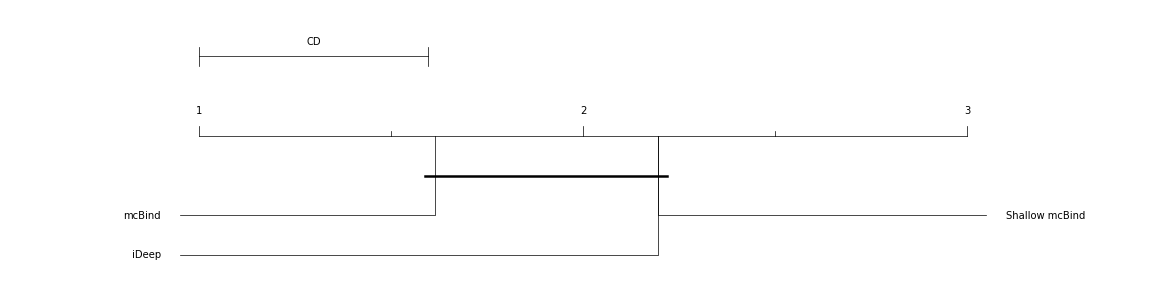

<Figure size 576x396 with 0 Axes>

In [18]:
import Orange

ranks = table.rank(axis=1, method="min", ascending=False)
avranks = ranks.mean()
names = table.columns.to_list()
cd = Orange.evaluation.compute_CD(avranks, 31)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, textspace=1)

fig = plt.gcf()
fig.set_size_inches(16, 4)

plt.show()
plt.savefig("results/critical_difference_shalow.png")

In [10]:
with open("results/set_{}/{}/predictions".format(0, "17_ICLIP_HNRNPC_hg19"), "rb") as predictions_file:
    loaded_predictions = np.load(predictions_file)
    loaded_predictions[1]

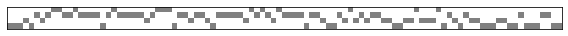

In [11]:
from utils import get_cobinding, get_fold, get_seq, get_region
fig, ax = plt.subplots()
ax.matshow(get_seq("17_ICLIP_HNRNPC_hg19", "test", 0)[1].T, cmap="binary", alpha=0.5, interpolation="none")
ax.margins(0)
ax.tick_params(
    left=False,
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labeltop=False
)
fig.tight_layout()
plt.savefig("seq.svg")

In [12]:
fig, ax = plt.subplots()
ax.matshow(get_fold("17_ICLIP_HNRNPC_hg19", "test", 0)[1].T, cmap="binary", alpha=0.5, interpolation="none")
ax.margins(0)
ax.tick_params(
    left=False,
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labeltop=False
)
fig.tight_layout()
plt.savefig("fold.svg")

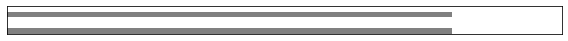

In [13]:
fig, ax = plt.subplots()
ax.matshow(get_region("17_ICLIP_HNRNPC_hg19", "test", 0)[1].T, cmap="binary", alpha=0.5, interpolation="none")
ax.margins(0)
ax.tick_params(
    left=False,
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labeltop=False
)
fig.tight_layout()
plt.savefig("region.svg")

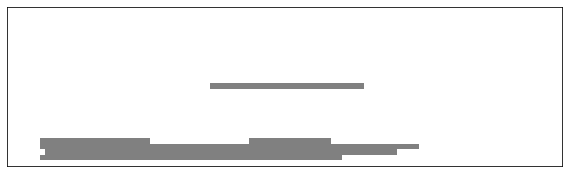

In [14]:
fig, ax = plt.subplots()
ax.matshow(get_cobinding("17_ICLIP_HNRNPC_hg19", "test", 0)[1].T, cmap="binary", alpha=0.5, interpolation="none")
ax.margins(0)
ax.tick_params(
    left=False,
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labeltop=False
)
fig.tight_layout()
plt.savefig("clip.svg")
